In [1]:
import pandas as pd
import numpy as np
import time
import seaborn as sns
import matplotlib.pyplot as plt
import requests
from bs4 import BeautifulSoup
import itertools
from scipy.ndimage import measurements
from skimage.morphology import label

from z3 import *
from IPython.display import Markdown, display

In [2]:
url='https://www.janestreet.com/puzzles/current-puzzle/'
res = requests.get(url)
soup = BeautifulSoup(res.content, 'html.parser')
y =[text for text in soup.body.stripped_strings]
#display([(i,j) for i,j in enumerate(y)])
display(Markdown("### "+y[8]+"\n\n"+str("\n".join(y[9:11]))))

### It's Symmetric 2

Shade some of the cells in the grid above so that the region of shaded
cells is connected and symmetric in some way (either by rotation or
reflection). Some of the cells have been numbered. These cells are in
the shaded region, and the numbers denote the products of the number
of shaded cells one can “see” within the region, in each of the 4
cardinal directions, before encountering an unshaded cell. (As in the
example, above.)
The answer to this puzzle is the sum of the squares of the areas of
connected unshaded squares in the completed grid. (Squares are
“connected” if they are orthogonally adjacent.)

<img src="https://www.janestreet.com/puzzles/2021-07-01-its-symmetric-2.png
          " width="400">

(0.0, 13.0, 13.0, 0.0)

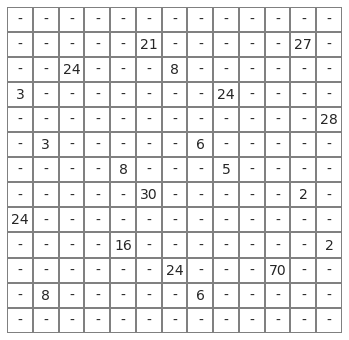

In [4]:
# Set up the grids to be solved (t)

grid1 =  np.array([[0, 0, 8, 0, 0],
                  [0, 0, 0, 0, 2],
                  [0, 0, 4, 0, 0],
                  [3, 0, 0, 0, 0],
                  [0, 0, 2, 0, 0]],dtype=int)

soln1 =  np.array([[1, 1, 1, 1, 1],
                  [1, 0, 1, 1, 1],              
                  [1, 1, 1, 0, 1],
                  [1, 1, 0, 0, 0],
                  [1, 1, 1, 0, 0]],dtype=int)

grid = np.array([[ 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                 [ 0, 0, 0, 0, 0,21, 0, 0, 0, 0, 0,27, 0],
                 [ 0, 0,24, 0, 0, 0, 8, 0, 0, 0, 0, 0, 0],
                 [ 3, 0, 0, 0, 0, 0, 0, 0,24, 0, 0, 0, 0],
                 [ 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,28],
                 [ 0, 3, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0],
                 [ 0, 0, 0, 0, 8, 0, 0, 0, 5, 0, 0, 0, 0],
                 [ 0, 0, 0, 0, 0,30, 0, 0, 0, 0, 0, 2, 0],
                 [24, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                 [ 0, 0, 0, 0,16, 0, 0, 0, 0, 0, 0, 0, 2],
                 [ 0, 0, 0, 0, 0, 0,24, 0, 0, 0,70, 0, 0],
                 [ 0, 8, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0],
                 [ 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]],
                dtype=int)

fig,ax = plt.subplots(1,1,figsize=(6,6))
y = grid.astype('str')
y[y=="0"] ="-"
sns.heatmap(np.zeros_like(grid),annot=y,cmap='Greys',cbar=False,linecolor="grey",linewidths=1,fmt="",annot_kws={"size":14})
ax.axis('off')

In [29]:
# function to do the looks ()
def find(data,N):
    data += [0] * max(0, N - len(data))
    if N==13:
        return      If(data[1]==0,1,
                    If(data[2]==0,1,
                    If(data[3]==0,2,
                    If(data[4]==0,3,
                    If(data[5]==0,4,
                    If(data[6]==0,5,
                    If(data[7]==0,6,
                    If(data[8]==0,7,
                    If(data[9]==0,8,
                    If(data[10]==0,9,
                    If(data[11]==0,10,
                    If(data[12]==0,11,12)                
                   )))))))))))
    else:
        return     If(data[1]==0,1,
                   If(data[2]==0,1,
                   If(data[3]==0,2,
                   If(data[4]==0,3,4)
                   )))

# neighbour checks to simplify the connected check
def neighbours(i,j,N):
    l=[]
    if i-1 >= 0:
        l.append((i-1,j))
    if i+1 < N:
        l.append((i+1,j))
    if j-1 >= 0:
        l.append((i,j-1))
    if j+1 < N:
        l.append((i,j+1))
    return l

#main code
def solve(grid,fixed=np.ones_like(grid,dtype=int)*-1,sym_type=1):
    start = time.time()
    N = grid.shape[0]

    #set up the solver and variables.
    s = Solver()
    X = np.array([[Int("X_%s%s" % (i+1,j+1)) for j in range(N) ] for i in range(N) ],dtype=object)

    # limit the values and place the fixed values
    s += [Or(X[i,j]==0,X[i,j] ==1) for j in range(N) for i in range(N) ]
    s += [X[i,j] == int(fixed[i,j]) for j in range(N) for i in range(N) if fixed[i,j] != -1]
    
    # the numbered cells = 1
    s+= [X[i,j] == 1 for j in range(N) for i in range(N) if grid[i,j] != 0]
        
    # force symmetry .. based on the options chosen
    if sym_type == 0:
        pass
    
    elif sym_type == 1:
        test = np.rot90(np.fliplr(X))
        s += [X[i,j] == test[i,j] for j in range(N) for i in range(N)]             
        
    elif sym_type == 2:
        cut = X[:-1,:]
        test = np.rot90(cut,2)
        s += [cut[i,j] == test[i,j] for j in range(N) for i in range(N-1)]
    
    # find the looks
    for i,j in itertools.product(range(N),range(N)):
        val = grid[i,j]
        if val != 0:
            top = find([X[x,j] for x in range(i,-1,-1)],N)
            bot = find([X[x,j] for x in range(i,N)],N)
            lhs = find([X[i,x] for x in range(j,-1,-1)],N)
            rhs = find([X[i,x] for x in range(j,N)],N)
            s += top*bot*lhs*rhs == int(val)
                        
    # at least one neighbour. Cut down the connectivity a bit.
    s += [Implies(X[i,j] !=0,Or([X[k][l] !=0 for (k,l) in neighbours(i,j,N)])) for j in range(N) for i in range(N) ] 
        
    # coding up the connectivity is hard so just solve and test then exclude solutions that are not connected
    count = 0
    while True: 
        #for a in s.assertions():
        #    print(a)
        if s.check() == sat:
            count += 1
            m = s.model()
            x = np.array([[m.evaluate(X[i,j]).as_long() for j in range(N)] for i in range(N)])
            if np.max(label(x != 0,connectivity=1)) == 1 :
                print('{} solutions took {:0.4f} seconds'.format(count,time.time()-start))
                yield x,grid
            s += Or([X[i][j]!=int(x[i,j]) for j in range(N) for i in range(N)])
        else:
            break
            
# Sum of squares of blank areas          
def answer(grid):
    labels, num = measurements.label(grid==0)
    areas = measurements.sum(grid==0, labels, index=range(1, num+1))
    print(areas,sum(areas**2))
    return np.sum([i**2 for i in areas])

1 solutions took 0.2683 seconds


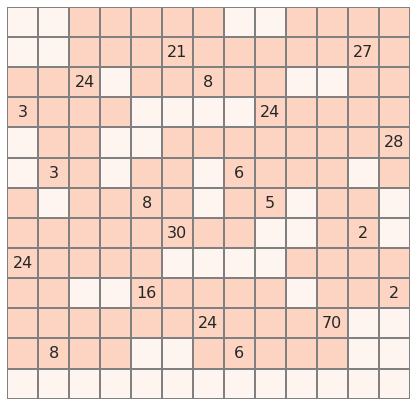

[ 4.  2.  1.  2.  7.  2.  2.  1.  1.  7.  2.  2.  1. 19.] 503.0


**The solution is 503**

Test symmetry is:  True


In [32]:
# after looking at the forced cells the 180 degree rotation symmetry pops out.
# 27 has to have 3 & 7 and there is only one way of doing that 
# which means the 21 has 7 the other way giving row 2 columns 3-13 as forced. Similar for the 70 the 10 is forced 
# then looked to see how that could be done. 
# The bottom row can all be zeros, but the top row can't
#
# Is a unique solution which is encouraging

soln = np.ones_like(grid)*-1
soln[-1,:]=0

for out,fix in solve(grid,fixed=soln,sym_type =2):
    fig,ax = plt.subplots(1,1,figsize=(out.shape[0]**.5*2,out.shape[1]**.5*2)) 
    y = np.array(fix).astype('int').astype('str')
    y[y=="0"] =""
    sns.heatmap(out,annot=y,cbar=False,cmap="Reds",fmt="",linewidths=1,center=3,linecolor="grey",annot_kws={"size":16})
    ax.axis("off")
    plt.show()
    display(Markdown("**The solution is {:,.0f}**".format(answer(out))))

print("Test symmetry is: ",np.all(out[:-1,:] == np.rot90(out[:-1,:],2)))

In [27]:
# Pull in the puzzle solution and grids from the solution page
url='https://www.janestreet.com/puzzles/solutions/december-2020-solution/'
res = requests.get(url)
soup = BeautifulSoup(res.content, 'html.parser')
x =[text for text in soup.body.stripped_strings]
display(Markdown(("### "+x[6]+"\n"+" ".join(x[7:9]))))

### Contact us
What We Do Our Philosophy

<img src="" width="400">

1 solutions took 0.0419 seconds


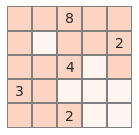

[1. 6.] 37.0


**The solution is 37**

2 solutions took 0.1200 seconds


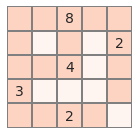

[1. 5. 1.] 27.0


**The solution is 27**

3 solutions took 0.1777 seconds


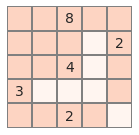

[5. 1.] 26.0


**The solution is 26**

4 solutions took 0.2365 seconds


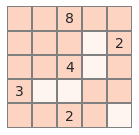

[2. 2. 1.] 9.0


**The solution is 9**

5 solutions took 0.2944 seconds


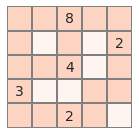

[1. 2. 2. 1.] 10.0


**The solution is 10**

In [12]:
for out,fix in solve(grid1,sym_type=1):
    fig,ax = plt.subplots(1,1,figsize=(out.shape[0]**.5,out.shape[1]**.5)) 
    y = np.array(fix).astype('int').astype('str')
    y[y=="0"] =""
    sns.heatmap(out,annot=y,cbar=False,cmap="Reds",fmt="",linewidths=1,center=3,linecolor="grey",annot_kws={"size":14})
    ax.axis("off")
    plt.show()
    display(Markdown("**The solution is {:,.0f}**".format(answer(out))))    

In [20]:
for a in s.assertions():
    print(a)

NameError: name 's' is not defined